# PU learning techniques applied to artificial data

## "Blobs" data set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from pu_learning import spies
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logging.debug("Initiating logger...")
plt.rcParams['figure.figsize'] = 9, 7
plt.rcParams['font.size'] = 14

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Data for example 1. Skip executioin of next cell if you want to use blobs.

In [2]:
# Create the data set BLOBS
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y > 1).astype(int)  # Convert the original labels [0,1,2,3] to [0,1]

Data for example 2.

In [3]:
# # Create the data set CIRCLES
# X, y = make_circles(
#     n_samples = 6000, noise = 0.1, 
#     shuffle = True, factor = .65
# )

6000 data points and 2 features
3000 positive out of 6000 total
300 positive out of 6000 total


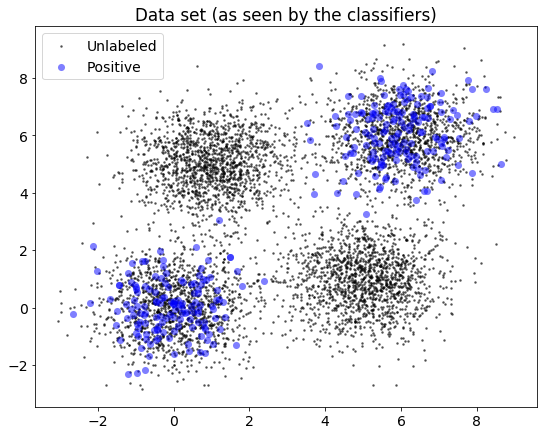

In [4]:
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2700
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

# Plot the data set, as the models will see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

## Randomforest classifier

In [5]:
%%time

rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_rf' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_rf'])

print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((rf.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_rf'])))

Accuracy - 55.0%, AUC - 0.9411
Wall time: 3.78 s


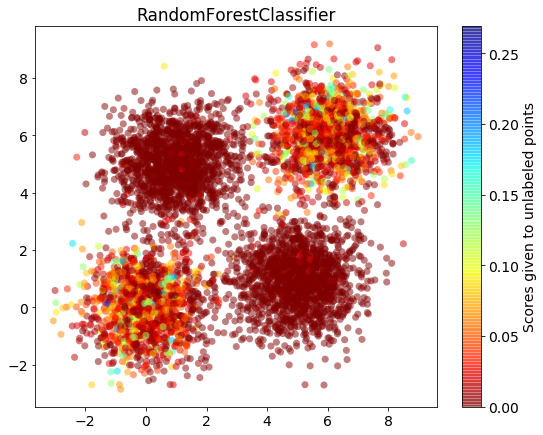

In [6]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_rf, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('RandomForestClassifier')
plt.show()

# SVM

In [7]:
%%time

# model = spies(XGBClassifier(), XGBClassifier())
model = SVC(probability=True)
model.fit(X, y)
results['output_svm'] = model.predict_proba(X)[:,1]
print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((model.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_svm'])))

Accuracy - 50.0%, AUC - 0.9211
Wall time: 712 ms


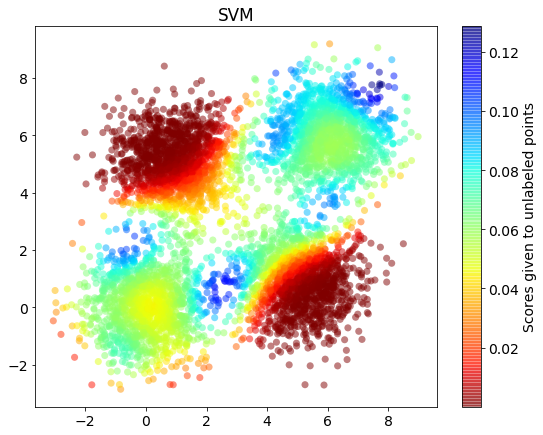

In [8]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_svm, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('SVM')
plt.show()

# Spies-RandomForest

In [9]:
%%time

model = spies(RandomForestClassifier(n_estimators = 1000, n_jobs = -1),
              RandomForestClassifier(n_estimators = 1000, n_jobs = -1))
model.fit(X, y)
results['output_spies_rf'] = model.predict_proba(X)
print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((model.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_spies_rf'])))

Accuracy - 76.5%, AUC - 0.9825
Wall time: 7.97 s


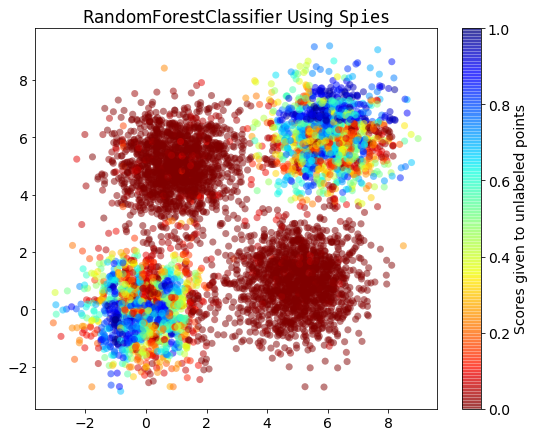

In [10]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_spies_rf, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'RandomForestClassifier Using ${\tt Spies}$')
plt.show()

# Spies-SVM

In [11]:
%%time

model = spies(SVC(probability=True), SVC(probability=True))
model.fit(X, y)
results['output_spies'] = model.predict_proba(X)
print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((model.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_spies'])))

Accuracy - 96.3%, AUC - 0.9966
Wall time: 659 ms


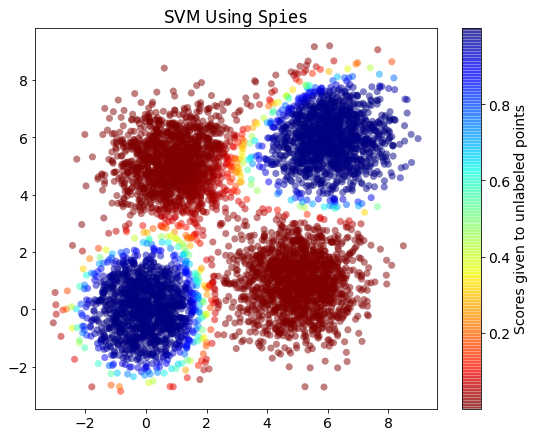

In [12]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_spies, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'SVM Using ${\tt Spies}$')
plt.show()

## Comparison of approaches

In [13]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_rf, y_svm, y_spies, y_spies_rf = [], [], [], []
for t in ts:
    y_rf.append(
        results[results.label == 0].sort_values(
            'output_rf', ascending = False
        ).head(t).truth.mean()
    )
    
    y_svm.append(
        results[results.label == 0].sort_values(
            'output_svm', ascending = False
        ).head(t).truth.mean()
    )
    
    y_spies.append(
        results[results.label == 0].sort_values(
            'output_spies', ascending = False
        ).head(t).truth.mean()
    )

    y_spies_rf.append(
        results[results.label == 0].sort_values(
            'output_spies_rf', ascending = False
        ).head(t).truth.mean()
    )

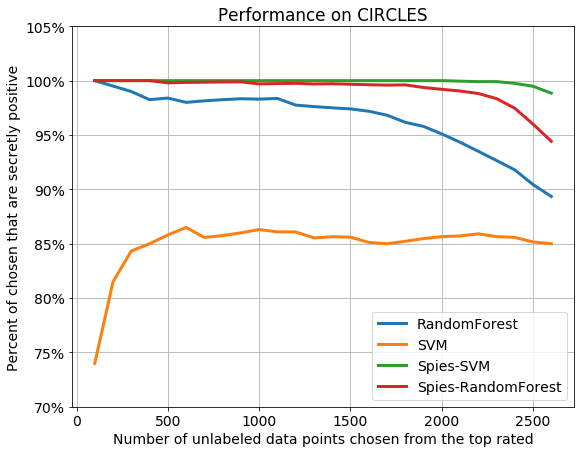

In [14]:
# Performance graphing
plt.plot(
    ts, y_rf,
    ts, y_svm,
    ts, y_spies,
    ts, y_spies_rf,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'RandomForest', 
    'SVM',
    'Spies-SVM',
    'Spies-RandomForest'
])
ylim = plt.gca().get_ylim()
plt.title('Performance on CIRCLES')
plt.grid()
plt.show()

# Experiments Records


|          Method      | Run time    | Accuracy | AUC |
|:-------------------------- | :----------- | :------- | :------ |
| RandomForest           | 2.57 s     | 0.55   |  0.941   |
| SVM                 | 0.69 s     | 0.50    | 0.921  |
| Spies (RandomForest)      | 6.50 s     | 0.77   |  0.983   |
| Spies (SVM)            | 0.70 s    |  0.96   |  0.997 |

